<a href="https://colab.research.google.com/github/Albly/Numerical_Linear_Algebra/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem set 2 (45 + 50 + 33 + 15 = 143 pts)

## Problem 1 (LU decomposition) 45 pts


### 1. LU  for band matrices and Cholesky decomposition (13 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of matrices –– band matrices with top left entry equal to 1 and the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively. The bands may be ```[1, 2, 1]``` and ```[1, 1, 2, 1, 1]``` respectively

- (4 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with top left entry equal to 1 with given diagonal bands. 
For example, input parametres ```(diag_broadcast = [1,2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
1 & 1 & 0 & 0\\
1 & 2 & 1 & 0 \\
0 & 1 & 2 & 1 \\
0 & 0 & 1 & 2 \\
\end{pmatrix}.$$

Provide the extensive testing of the implemented function that will works correctly for large $n$,  e.g. $n=100$.
As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).

- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

- (7 pts) Write a function ```cholesky(n)``` for computing Cholesky decomposition. It should take the the single argument - the matrix that will be factorized and return the single output - lower-triangular factor $L$. Think about the efficiency of your implementation and if necessary update it to achieve the best performance (eliminate Python loops, where it is possible and so on). Explicitly describe the difference with LU decomposition that reduces the complexity from $2n^3/3$ for LU to $n^3/3$ for Cholesky. 
Test the implemented function on the Pascal matrix of given size $n$ for $n = 5, 10, 50$. 
Pascal matrix is square matrix of the following form (here for $n=4$)
$$P = \begin{pmatrix}
1 & 1 & 1 & 1\\
1 & 2 & 3 & 4 \\
1 & 3 & 6 & 10 \\
1 & 4 & 10 & 20 \\
\end{pmatrix}.$$

    [Here](https://en.wikipedia.org/wiki/Pascal_matrix) you can find more details about such matrices and analytical form for factor $L$ from Cholesky decomposition. Compare the result of your implementation with analytical expression in terms of some matrix norm of difference.  

In [ ]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import scipy 
from scipy import linalg
import numpy as np
import warnings
import matplotlib.pyplot as plt
from numba import njit

# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones;                  add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.

@njit(fastmath=True)
def band_lu(diag_broadcast, n):
    # enter your code here
    if len(diag_broadcast) ==3:
        a_low_diag, a_diag, a_up_diag = diag_broadcast

        L = np.zeros((1, n-1)) # prepare lower diagonal matrix 
        U = np.zeros((n, 2))   # prepare upper diag matrix

        # do initialization
        U[0][0] = 1     # Upper left entire 
        U[0:n-1, 1] = a_up_diag     # Upper diagonal elemetns for U matrix 

        for i in range(0, n-1):
            if U[i,0] == 0:         # if diag entire == 0, cannot find LU because of zero division
                print("LU doesn't exist. Nothing will be returned")
                return None         # finish with nothing

            L[0,i] = a_low_diag / U[i,0]        # i-th lower diag element L matrix 
            U[i+1,0] = a_diag - L[0,i] * U[i,1] # i-th diag element of U matrix
        return L,U 

    if len(diag_broadcast) == 5:
        a_low_low_diag, a_low_diag, a_diag, a_up_diag, a_up_up_diag = diag_broadcast

        L = np.zeros((2, n-1))  # L matrix with low_low_diag and low_diag
        U = np.zeros((n, 3))    # U matrix with diag, up_diag, up_up_diag 

        # do initialization
        U[0][0] = 1
        U[0][1] = a_up_diag 
        U[0:n-2][2] = a_up_up_diag

        for i in range(0, n-1):
            if U[i,0] == 0:     # if zero then LU doesnt exist. 
                print("LU doesn't exist. Nothing will be returned")
                return None         # finish with nothing
            
            if i == 0:
                L[1][i] = a_low_diag / U[i][0]              # low diag
                U[i+1][0] = a_diag - L[1][i]*U[i][1]        # diag
            
            elif i >= 1 and i <= n-2:
                L[0][i] = a_low_low_diag / U[i-1, 0]                    # low-low diag
                L[1][i] = (a_low_diag - L[0][i]*U[i-1][1] / U[i,0])     # low diag
                U[i+1][0] = a_diag - L[0][i]*U[i-1][2] - L[1,i] *U[i,1] # diag

            if i <= n-3:
                U[i+1, 1] = a_up_diag - L[1,i] * U[i,2]     # up diag
        return L,U    
    else:
        print("Only 3 and 5 diag matrix works. Nothing will be returned")
        return None
        
#@njit(fastmath=True)
def cholesky(A):
    # enter your code here
    L = np.zeros(A.shape, dtype = object)
    n = A.shape[0]

    # do initialization
    L[0,0] = A[0,0]**0.5
    L[1:n,0] = A[1:n,0] /L[0,0]

    for i in range(1,n):
        L[i][i] = (A[i,i] - sum( L[i,0:i]**2) )**0.5

        for j in range( i+1 ,n ):
            L[j][i] = (A[j,i] - sum(L[j,0:i] * L[i,0:i])) / L[i,i] 
    return L

In [ ]:
# Your solution is here
def get_task_matrix(diag_broadcast,n):
    '''Function wich generates matrices from task'''
    if len(diag_broadcast) == 3:        
        diags_pos  = [-1,0,1]
    elif len(diag_broadcast) == 5:
        diags_pos = [-2,-1,0,1,2]

    A = diags(diag_broadcast,diags_pos, shape=(n,n)).toarray()
    A[0,0] = 1
    return A

def to_dense(n,L,U, N_diags):
    '''From our diag from transform L and U to dense usual form'''
    if N_diags == 3:
        L0 = np.eye(n) + diags(L[0,:], -1).toarray()
        U0 = diags([U[:,0],U[:,1]],[0,1]).toarray()
    
    elif N_diags == 5:
        L0 = np.eye(n) + diags([L[0,1:],L[1,:]], [-2,-1]).toarray()
        U0 = diags([U[:,0],U[:,1],U[:,2]],[0,1,2]).toarray()

    return L0, U0

diag_broadcast, n = [6, 4, -2], 75

L0,U0 = band_lu(np.array(diag_broadcast), n)

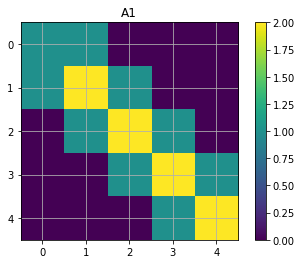

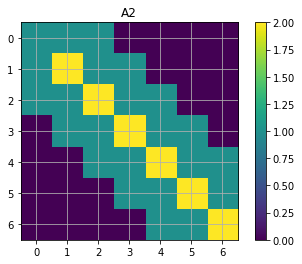

In [ ]:
# Check matrices
diag_broadcast, n = [1, 2, 1], 5
A1 = get_task_matrix(diag_broadcast,n)
plt.figure()
plt.imshow(A1)
plt.title('A1')
plt.grid()
plt.colorbar()
diag_broadcast, n = [1, 1, 2, 1, 1], 7
A2 = get_task_matrix(diag_broadcast,n)
plt.figure()
plt.imshow(A2)
plt.title('A2')
plt.colorbar()
plt.grid()

In [ ]:
# Comparisson initial matrix with calculated from LU

diag_broadcast = [1, 2, 1]
n = 100
test_matrix = get_task_matrix(diag_broadcast,n)
L_band,U_band = band_lu(np.array(diag_broadcast), n)
L, U = to_dense(n, L_band, U_band, 3)

print('All correct :', np.isclose(test_matrix, L @ U).all())

All correct : True


---

**1.1.2(2 pts) Compare execution time of the band LU decomposition using standard function from scipy, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.**

In [ ]:
# Calculate time
from tqdm.notebook import tqdm 

sizes = np.linspace(50, 5000, 30, dtype=int)

diag_3_broadcast = np.array([1, 2, 1])
diag_5_broadcast = np.array([1, 1, 2, 1, 3])

band_lu_3 = []
scipy_lu_3 = []
band_lu_5 = []
scipy_lu_5 = []

for size in tqdm(sizes):
    A3 = get_task_matrix(diag_3_broadcast, size)            
    A5 = get_task_matrix(diag_5_broadcast, size)

    time_band_3  = %timeit -o -q -n3 band_lu(diag_3_broadcast, size)
    time_band_5  = %timeit -o -q -n3 band_lu(diag_5_broadcast, size)
    time_scipy_3 = %timeit -o -q -n3 scipy.linalg.lu(A3 , permute_l=False) 
    time_scipy_5 = %timeit -o -q -n3 scipy.linalg.lu(A5 , permute_l=False) 
    
    band_lu_3.append(time_band_3.best)
    band_lu_5.append(time_band_5.best)
    scipy_lu_3.append(time_scipy_3.best)
    scipy_lu_5.append(time_scipy_5.best)

  0%|          | 0/30 [00:00<?, ?it/s]

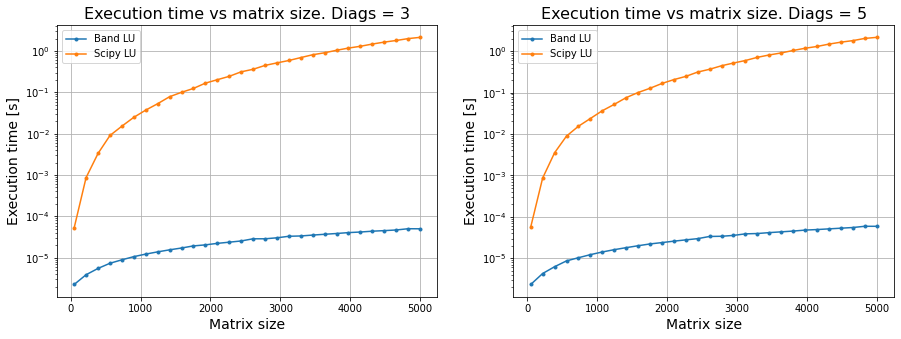

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(sizes, band_lu_3,'.-', label = 'Band LU')
plt.plot(sizes, scipy_lu_3,'.-', label = 'Scipy LU')
plt.legend()
plt.grid()
plt.xlabel('Matrix size', fontsize =14)
plt.ylabel('Execution time [s]',fontsize = 14)
plt.yscale('log')
plt.title('Execution time vs matrix size. Diags = 3', fontsize = 16)

plt.subplot(1,2,2)
plt.plot(sizes, band_lu_5,'.-', label = 'Band LU')
plt.plot(sizes, scipy_lu_5,'.-', label = 'Scipy LU')
plt.legend()
plt.grid()
plt.xlabel('Matrix size', fontsize =14)
plt.ylabel('Execution time [s]',fontsize = 14)
plt.yscale('log')
plt.title('Execution time vs matrix size. Diags = 5', fontsize = 16)
plt.show()

Finally, we can say that our band LU method works faster than scipy usual method. Complexity of our method is linear while scipy's is cubic.

___


**1.1.3 (7 pts) Write a function ```cholesky(n)``` for computing Cholesky decomposition. It should take the the single argument - the matrix that will be factorized and return the single output - lower-triangular factor $L$. Think about the efficiency of your implementation and if necessary update it to achieve the best performance (eliminate Python loops, where it is possible and so on). Explicitly describe the difference with LU decomposition that reduces the complexity from $2n^3/3$ for LU to $n^3/3$ for Cholesky. 
Test the implemented function on the Pascal matrix of given size $n$ for $n = 5, 10, 50$. 
Pascal matrix is square matrix of the following form (here for $n=4$)
$$P = \begin{pmatrix}
1 & 1 & 1 & 1\\
1 & 2 & 3 & 4 \\
1 & 3 & 6 & 10 \\
1 & 4 & 10 & 20 \\
\end{pmatrix}.$$**

In [ ]:
n = 5
P = scipy.linalg.pascal(n, kind='symmetric', exact = True)
L = cholesky(P)
print('Frobenius norm of difference with n = 5 is', np.sum(np.abs(L @ L.T - P)**2))
# -----------------------------------------------------------------------------------
n = 10
P = scipy.linalg.pascal(n, kind='symmetric', exact = True)
L = cholesky(P)
print('Frobenius norm of difference with n = 10 is', np.sum(np.abs(L @ L.T - P)**2))
# -----------------------------------------------------------------------------------
n = 50
P = scipy.linalg.pascal(n, kind = 'symmetric', exact = True)
L = cholesky(P)
print('Frobenius norm of difference with n = 50 is', np.sum(np.abs(L @ L.T - P)**2))

Frobenius norm of difference with n = 5 is 0.0
Frobenius norm of difference with n = 10 is 0.0
Frobenius norm of difference with n = 50 is 0.011144022750634613


**Compare the result of your implementation with analytical expression in terms of some matrix norm of difference.**

Analytical expression can be calcualted as follows:
$$
L_{ij} = \frac{i!}{j!(i-j)!}, j \leq i, \qquad i \in [0,n-1]
$$
Lets use popular and well interpreted choise - Frobenius norm for difference calculation.

In [ ]:
@njit(fastmath=True)
def factorial(n):
    return np.prod(np.arange(1,n+1))

def L_analytical(n):
    L = np.zeros((n,n), dtype=object)
    for i in range(0, n):
        for j in range(0, i+1):
            L[i,j] = factorial(i) / factorial(j) / factorial(i-j)
    return L

n = 5
P = scipy.linalg.pascal(n, kind='symmetric', exact=True)
L = cholesky(P)
L_a = L_analytical(n)
print('Frobenius norm of difference with n = 5 is', np.sum(np.abs(L_a - L)**2))
# -----------------------------------------------------------------------------------
n = 10
P = scipy.linalg.pascal(n, kind='symmetric', exact=True)
L = cholesky(P)
L_a = L_analytical(n)
print('Frobenius norm of difference with n = 10 is', np.sum(np.abs(L_a - L)**2))
# -----------------------------------------------------------------------------------
n = 50
P = scipy.linalg.pascal(n, kind='symmetric', exact=True)
L = cholesky(P)
L_a = L_analytical(n)
print('Frobenius norm of difference with n = 50 is', np.sum(np.abs(L_a - L)**2)) # something scary

Frobenius norm of difference with n = 5 is 0.0
Frobenius norm of difference with n = 10 is 0.0
Frobenius norm of difference with n = 50 is 3.7805734095298863e+28


### 2. Stability of LU (8 pts)


* **1.2.1(4 pts) Show, that for these  matrices $A$ and $B$ LU decomposition fails. Why does it happen?**

$
A = \begin{pmatrix}
0 & 1 \\
2 & 3
\end{pmatrix}.$ 

$B = \begin{pmatrix}
1 & 1 & 0\\
1 & 1 & 2 \\
1 & 2 & 1
\end{pmatrix}.$ 

Lets write the calculations:
$$
A = \begin{pmatrix}
0 & 1 \\
2 & 3
\end{pmatrix}
=
LU
=
\begin{pmatrix}
l_{11} & 0 \\
l_{21} & l_{22}
\end{pmatrix}
\begin{pmatrix}
u_{11} & u_{12} \\
0 & u_{22}
\end{pmatrix}
=
\begin{pmatrix}
l_{11}u_{11} & l_{11}u_{12} \\
l_{21}u_{11} & l_{21}u_{12} + l_{11}u_{22}
\end{pmatrix}
$$

Finally we have system of equations:
$$
 \begin{cases}
 l_{11}u_{11} = 0\\
 l_{11}u_{12} = 1\\
 l_{21}u_{11} = 2\\
 l_{21}u_{12} + l_{11}u_{22} = 3\\
 \end{cases}
$$

However first 3 equations are contradict with each other, that is the reason of the fail.

Lets do the same with second matrix:

$$
B = \begin{pmatrix}
1 & 1 & 0\\
1 & 1 & 2 \\
1 & 2 & 1
\end{pmatrix}
=
LU
=
\begin{pmatrix}
l_{11} & 0 & 0 \\
l_{21} & l_{22} & 0 \\
l_{31} & l_{32} & l_{33} \\
\end{pmatrix}
\begin{pmatrix}
u_{11} & u_{12} & u_{13} \\
0 & u_{22} & u_{23} \\
0 & 0 & u_{33}
\end{pmatrix}
=
\begin{pmatrix}
l_{11}u_{11} & l_{11}u_{12} & l_{11}u_{13}\\
l_{21}u_{11} & l_{21}u_{12} + l_{22}u_{22} & l_{21}u_{13} + l_{22}u_{23}\\
l_{31}u_{11} & l_{31}u_{12} + l_{32}u_{22} & l_{31}u_{13} + l_{32}u_{23} + l_{33}u_{33}\\
\end{pmatrix}
$$ 

After obvious simplifications we will get following system of equations:
$$
\begin{cases}
l_{22}u_{22} = 0\\
l_{22}u_{23} = 2\\
l_{32}u_{22} = 1\\
l_{32}u_{23} + l_{33}u_{33} = 1\\
\end{cases}
$$
And again we have here contradictions with terms $l_{22}$ or $u_{22}$

---

* **(4 pts) In the LU decomposition, a pivot position is a position of the element that identifies the row and column that will be eliminated in the current step. For example, first pivot in LU is usually the left top element. What value of $c$ leads to zero in the second pivot position? What $c$ produces zero in the third pivot position? What modification of LU should we use in order to address the possible zeros in pivot position?**

$A = \begin{pmatrix}
1 & c & 0\\
2 & 4 & 1 \\
3 & 5 & 1
\end{pmatrix}.$ 

Assume the main daigonal of $L$ consists of 1, then lets write lu decomposition for matrix $A$:
$$
A = 
LU
=
\begin{pmatrix}
1 & c & 0\\
2 & 4 & 1 \\
3 & 5 & 1
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & 0 \\
l_{21} & 1 & 0 \\
l_{31} & l_{32} & 1 \\
\end{pmatrix}
\begin{pmatrix}
u_{11} & u_{12} & u_{13} \\
0 & u_{22} & u_{23} \\
0 & 0 & u_{33}
\end{pmatrix}
$$

Now we can say that $u_{11} = 1, u_{12} = c, u_{13} = 0$. Then we can find that $l_{21} = 2$ as $l_{21}u_{11} = 2$. Then we can find that $u_{22} = 4-2c$, from $l_{21}u_{12}+u_{22} = 4$. 
So, $u_{22}$ is the second pivot. Lets make it equal to 0, then $c=2$. 

Now we can find:

$u_{23} =1 \quad$ from $l_{21}u_{12}+u_{23}=1$

$l_{31} = 3$ $\quad$ from $l_{31}u_{11} = 3$

$l_{32} = \frac{5-3c}{4-2c} \quad$ from $l_{31}u_{12}+l_{32}u_{22} = 5$

$u_{33} = \frac{c-1}{4-2c} \quad$ from $l_{31}u_{13}+l_{32}u_{23}+u_{33} = 1$

And $u_{33}$ is the third pivot Making it equal to 0 makes $c = 1$.

Finally, $c = 1$ makes 0 in third pivot, and $c=2$ makes zero in second pivot

----

In [ ]:
# Your solution is here

### 3. Implementation of PLU decomposition (14 pts)

As you have noticed before, LU decomposition may fail. In order to make it stable, we can use LU decomposition with pivoting  (PLU).

We want to find such permutation matrix $P$ that LU decomposition of $PA$ exists

$$ PA = LU $$

- (7 pts) Implement efficiently PLU decomposition (without loops and with appropriate level of BLAS operations).  Also, pay attention to the way of permutation matrix storage.

- (4 pts ) Compare your function for computing PLU with built-in function on matrices of such type ```(mirror_diag = [1,2,1], n = 4)```. (Bandwidth and matrix size may vary). So, you can pass them as dense 2D NumPy array and do not tune your implementation to this special structure. Compare them in terms of running time (use ```%timeit``` magic) for range of dimensions to recover the asymptotic rate of time increasing and in terms of acuracy. We expect you plot the running time vs matrix dimension for built-in function and your implementation. So you should get the plot with two lines.
Consider additionally one of the pathological examples from above, where LU fails, but PLU has to work.


$$A = \begin{pmatrix}
0 & 0 & 1 & 1 \\
 0 &1 & 2 & 1  \\
 1 & 2 & 1  & 0\\
1 & 2  & 0 & 0  \\
\end{pmatrix}.$$


- (3 pts) Discuss the obtained results and explain how is it possible to accelerate computing the PLU factorization. 

NumPy or JAX are both ok in this problem, but please use the single library for all implementations. 

**1.3.1 (7 pts) Implement efficiently PLU decomposition (without loops and with appropriate level of BLAS operations). Also, pay attention to the way of permutation matrix storage.**

In [ ]:
# Your solution is here
@njit(fastmath = True)
def LUP(A):
    A = np.copy(A)
    n = A.shape[0]
    p = np.arange(0,n)  # permutation vec
    
    for i in range(n-1):
        pivot_idx = np.argmax(np.abs(A[i:n,i]))+ i    # find pivot index
        pivot_val = np.abs(A[pivot_idx,i])            # find pivot value
        if pivot_val != 0:
            p[i],p[pivot_idx] = p[pivot_idx],p[i]     # replace rows of p
            A[i,:],A[pivot_idx,:] = np.copy(A[pivot_idx,:]),np.copy(A[i,:])
            
            # LU decomposition
            for j in range(i+1, n):
                A[j,i] = A[j,i] / A[i,i]
                A[j,i+1:n] = A[j,i+1:n] - A[j,i] * A[i,i+1:n]
        else:
            print('Pivot is equal to 0. LUP does not exixst')
            return None
    L = np.tril(A,k=-1) + np.eye(n) 
    U = np.triu(A)
    P = np.eye(n)[:,p]      # reconstruct permutation matrix
    return P,L,U

In [ ]:
# Checking 
n = 99
A = np.random.randn(n,n)
P,L,U = LUP(A)

print('All correct: ',np.isclose(P @ L @ U,A).all())

All correct:  True


- 1.3.2 (4 pts ) Compare your function for computing PLU with built-in function on matrices of such type ```(mirror_diag = [1,2,1], n = 4)```. (Bandwidth and matrix size may vary). So, you can pass them as dense 2D NumPy array and do not tune your implementation to this special structure. Compare them in terms of running time (use ```%timeit``` magic) for range of dimensions to recover the asymptotic rate of time increasing and in terms of acuracy. We expect you plot the running time vs matrix dimension for built-in function and your implementation. So you should get the plot with two lines.
Consider additionally one of the pathological examples from above, where LU fails, but PLU has to work


$$A = \begin{pmatrix}
0 & 0 & 1 & 1 \\
 0 &1 & 2 & 1  \\
 1 & 2 & 1  & 0\\
1 & 2  & 0 & 0  \\
\end{pmatrix}.$$

  0%|          | 0/20 [00:00<?, ?it/s]

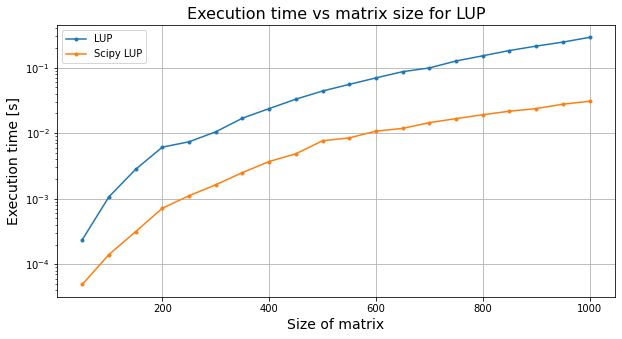

In [ ]:
def get_matrix(diag_broadcast, n):
    l = len(diag_broadcast)
    diag = []
    for i in range(l):
        diag.append(int(i-(l-1)/2))

    A = diags(diag_broadcast, diag, shape = (n,n)).toarray()
    return A


sizes = np.linspace(50, 1000, num = 20, dtype=int)
diag_brodcast = [1,2,1]

lup_times = []
scipy_times = []

for size in tqdm(sizes):
    A = get_matrix(diag_broadcast, size)
    
    lup_time = %timeit -o -q -n3 LUP(A)
    scipy_time = %timeit -o -q -n3 scipy.linalg.lu(A)
    lup_times.append(lup_time.best)
    scipy_times.append(scipy_time.best)
    

plt.figure(figsize=(10,5))
plt.plot(sizes ,lup_times, '.-', label = 'LUP')
plt.plot(sizes, scipy_times, '.-', label ='Scipy LUP')
plt.yscale("log")
plt.xlabel('Size of matrix', fontsize = 14)
plt.ylabel('Execution time [s]', fontsize = 14)
plt.title('Execution time vs matrix size for LUP', fontsize =16)
plt.legend()
plt.grid()
plt.show()


Cases where usual LU failed:

In [ ]:
A = np.array([[0,0,1,1],
              [0,1,2,1],
              [1,2,1,0],
              [1,1,0,0]])

P,L,U = LUP(A)
print('All correct:', np.isclose(P @ L @ U, A).all())

All correct: True


In [ ]:
diag_broadcast, n = [1, 1, 2, 1, 1], 7
A = get_task_matrix(diag_broadcast,n)
P,L,U = LUP(A)
print('All correct: ',np.isclose(P @ L @ U, A).all())

All correct:  True


In [ ]:
c = 2
A = np.array([[1,c,0],
            [2,4,1],
            [3,5,1]],dtype=np.float32)

P,L,U = LUP(A)
print('All correct: ', np.isclose(P @ L @ U,A).all())

All correct:  True


---

**1.3.3 (3 pts) Discuss the obtained results and explain how is it possible to accelerate computing the PLU factorization.**
According to obtained results, implemented function is slower than scipy implementation. I tried to use jit, but it doesn't help to beat the scipy function. Seems to me that we should ommit somehow loops to increase performance.

---

### 4. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <span style="color:red">Schur complement</span> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

---


* 1.4.1 (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <span style="color:red">Schur complement</span> of the block $A_{11}$.

Consider Schur complement: $S = A_{22} - A_{21}A_{11}^{-1}A_{12}$, we can rewrite the system of equations as follows:
$$
 \begin{cases}
   A_{11} u_1 + A_{12} u_2 = f_1\\
   A_{21} u_1 + A_{22} u_2 = f_2\\
 \end{cases}
$$
We have to multiply first equation by $ A_{21}A_{11}^{-1}$, then we will get:

$$
 \begin{cases}
   A_{21}A_{11}^{-1} A_{11} u_1 + A_{21}A_{11}^{-1} A_{12} u_2 = f_1A_{21}A_{11}^{-1}\\
   A_{21} u_1 + A_{22} u_2 = f_2\\
 \end{cases}
\Rightarrow
 \begin{cases}
   A_{21} u_1 + A_{21}A_{11}^{-1} A_{12} u_2 = A_{21}A_{11}^{-1} f_1 \\
   A_{21} u_1 + A_{22} u_2 = f_2 \\
 \end{cases}
$$

Finally we can subtract the first equation from the second one and get: 
$$
(A_{22} - A_{21}A_{11}^{-1} A_{12})u_2 = f_2 - A_{21}A_{11}^{-1} f_1 \Rightarrow S u_2 = \hat{f_2}
$$

----

* 1.4.2 (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.

Lets consider Schur complement determinant property for the such matrix:

$ S = \begin{bmatrix} A & B \\ C & D \end{bmatrix} $

Here we have 2 equalities which are: 
$$
\det(S) = \det(A) \det(D - CA^{-1}B) = \det(D) \det(A - BD^{-1}C)
$$

Lets rewrite right part: 
$$
\det(X)\det(I+BX^{-1}A) = \det(I)\det(X+AI^{-1}B) = \det(X+AB)
$$ 

---


* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$


Since we can write that $\det(I_n) = 1$ and $FI_n^{-1}G = FG$ then we simply can get that $\det(I_m - FG) = \det{(I_n)}\det(I_m - FI_n^{-1}G)$

Now, lets use Schur compliment property:
$ S = \begin{bmatrix} A & B \\ C & D \end{bmatrix} $

We have such 2 equalities:
$$
\det(S) = \det(A) \det(D - CA^{-1}B) = \det(D) \det(A - BD^{-1}C)
$$
Now we again can use the fact that $\det{(I_m)} = 1$ and $GI_m^{-1}F = GF$ to get such equation:
$$
\det{(I_n)}\det(I_m - FI_n^{-1}G) = \det{(I_m)}\det(I_n - GI_m^{-1}F) = \det(I_n - GF)
$$
And finally, we can see that:
$$
\det(I_m - FG) = \det(I_n - GF)
$$

---

In [ ]:
# Your solution is here

## Problem 2 (eigenvalues)  (50 pts)

### 1. Theoretical tasks (15 pts)

* (2 pts) Prove that eigenvectors that correspond to distinct eigenvalues are linearly independent.

* (3 pts) $A$ is a matrix such that $a_{i,j} \ge 0$ and $\sum_{j}a_{i,j} = 1$ (sum of the elements in each row is 1). Prove that $A$ has an eigenvalue $\lambda=1$ and that any eigenvalue $\lambda_i$: $|\lambda_i| \le 1$.

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block (there is only one $\varepsilon$ - in the left lower corner):

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     0 & \lambda & 1 & & \\ 
     & 0 & \ddots & \ddots & \\ 
     & & 0 & \lambda & 1 \\ 
     \varepsilon & & & 0 & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

   Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

**2.1.1 (2 pts) Prove that eigenvectors that correspond to distinct eigenvalues are linearly independent.**

Sequence of vectors $v_1 , v_2, \dots , v_k$ are linearly dependent if $\alpha_1v_1+\alpha_2v_2+ \dots+\alpha_kv_k = 0$. Where $\alpha_i$ are scalars, which are not equal to 0 simultaniously. Otherwise such vectors are linearly independent. 
Lets assume taht we have different eigenvalues $λ_i$ and corresponding eigenvectors $v_i$.
Assume that eigenvectors are linearly dependent, then:
$$
\alpha_1v_1 + \alpha_2v_2 + \dots + \alpha_{k+1}v_{k+1} = 0 \qquad (1) 
$$
and $α_i \neq 0, \forall i:i \in [1,2,\dots, k+1]$. As $Av_i = λ_iv_i$, then we can rewrite (1) as follows:
$$
\alpha_1λ_1v_1 + \alpha_2λ_2v_2 + \dots + \alpha_{k+1}λ_{k+1}v_{k+1} = 0 \qquad (2)
$$
Now, lets multiply (1) to $\lambda_{K+1}$:
$$
\alpha_1λ_{k+1}v_1 + \alpha_2λ_{k+1}v_2 + \dots + \alpha_{k+1}λ_{k+1}v_{k+1} = 0 \qquad (3)
$$

Now, lets substract (3) from (2). We will get:
$$
\alpha_1(λ_1 - λ_{k+1})v_1 + \alpha_2(λ_2 - λ_{k+1})v_2 + \dots + \alpha_k(λ_k - λ_{k+1})v_k = 0 
$$
All $λ_i$ is different, therefore from (1) we can say:
$$
\alpha_{k+1}v_{k+1} = 0 
$$
Since $v_{k+1}$ is non-zero eigenvector, then $a_{k+1}=0$. But this contradicts with what we assumed at the beginning. Therefore eigenvectors corresponding different eigenvalues are linearly independent.

--- 

**2.1.2 (3 pts)  A  is a matrix such that  ai,j≥0  and  ∑jai,j=1  (sum of the elements in each row is 1). Prove that  A  has an eigenvalue  λ=1  and that any eigenvalue  λi :  |λi|≤1 .**

Here we can use Gershgorin theorem, that states that all eigenvalues $\lambda_i,  i = 1, \ldots, n$ are located inside the union of Gershgorin circles $C_i$, where $C_i$ is a disk on the complex plane with center in $a_{ii}$ and radius $r_i = \sum_{j \ne i} |a_{ij}|$. Therefore $|\lambda_i| \leq r_i$

As $a_{i,j} \ge 0$ then following equalities are equal: 
$$
\sum_{j}|a_{i,j}| = \sum_{j}a_{i,j} = 1
$$

Then: 
$$
|\lambda_i| \leq r_i = \sum_{j \ne i} |a_{ij}| \leq \sum_{j} |a_{ij}| = \sum_{j} a_{ij} = 1 \Rightarrow |\lambda_i| \leq 1
$$

Now, we can show that there is at leas one eigenvalue equals to 1. For that we can use Perron-Frobenius theorem, that describes maximum eigenvalue as:
$$ 
\min _{i}\sum _{j}a_{ij}\leqslant \lambda_{m} \leqslant \max _{i}\sum _{j}a_{ij}$$ 

In our case it is the same as $1 \leqslant \lambda_{m} \leqslant 1$. Then, we can conclude that $\lambda_{m} = 1$

---

**2.1.3 (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy  |λ|=1**


From definition we know that complex square matrix $A$ is normal in case if:
$$
AA^H=A^HA
$$
And Hermitian matrix by definition is such as:
$$
A = A^H
$$
(1) Let's use specrtal decomposition of the normal matrix:$A = UΛU^H$ and $A^H = (UΛU^H)^H$. Here $Λ$ is diagonal and $U$ is unitary matrix.
Easy to see, that $UΛU^H = UΛ^HU^H$. Then $Λ = Λ^H$, which can be true only for real numbers.

(2) Now eigenvalues are real and $\Lambda$ is diagonal. Then $Λ=Λ^H$. Again, we use specrtal decomposition: $A = UΛU^H$ and $A^H = (UΛU^H)^H = UΛ^HU^H$. But then $A = A^H$, so it's Hermitian 

Now, lets prove that normal matrix is unitary iff its eigenvalues satisfy |λ|=1:

(1) From definition we know that matrix is unitary if $A^H = A^{-1}$.

Since $A$ is normal: 
$$
AA^H = A^HA = UΛU^HUΛ^HU^H = UΛ^HU^HUΛU^H = UΛ^HΛU^H = UΛ^2U^H 
$$
But as A unitary $AA^H = I$ then $UΛ^2U^H = I$ then $U^HUΛ^2U^HU = U^HIU$ and using unitary definition we will finally get $Λ^2 = I$. Therefore $|λ| = 1$  

(2)
$$AA^H = A^HA= UΛU^HUΛ^HU^H = UΛ^HU^HUΛU^H = UΛ^2U^H$$
Since we know that $|λ| =1$, then $Λ^2 = I$, therefore
$$
UΛ^2U^H = UIU^H = UU^H = I
$$
so A is unitary.

---

* **2.1.4(5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block (there is only one $\varepsilon$ - in the left lower corner):**

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     0 & \lambda & 1 & & \\ 
     & 0 & \ddots & \ddots & \\ 
     & & 0 & \lambda & 1 \\ 
     \varepsilon & & & 0 & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

   Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

## **Task 2.1.4**
**(5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block (there is only one $\varepsilon$ - in the left lower corner):
$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     0 & \lambda & 1 & & \\ 
     & 0 & \ddots & \ddots & \\ 
     & & 0 & \lambda & 1 \\ 
     \varepsilon & & & 0 & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$
Comment how eigenvalues of $J(0)$ are perturbed for large $n$.**

Lets see the resulting characteristic equation for matrices with different sizes.

For 2x2 :
$$
\begin{vmatrix}
\lambda - x & 1 \\
\varepsilon & \lambda - x \\
\end{vmatrix}
= 
(\lambda - x)^2 - \varepsilon
$$

For 3x3 :

$$
\begin{vmatrix}
\lambda - x & 1 & 0 \\
0 & \lambda - x & 1 \\
\varepsilon & 0 & \lambda - x &\\
\end{vmatrix}
= 
(\lambda - x)
\begin{vmatrix}
\lambda - x & 1 \\
0 & \lambda - x \\
\end{vmatrix}
-
\begin{vmatrix}
0 & 1 \\
\varepsilon & \lambda - x \\
\end{vmatrix}
= 
(\lambda - x)^3 + \varepsilon
$$

For 4x4

$$
\begin{vmatrix}
\lambda - x & 1 & 0 & 0\\
0 & \lambda - x & 1 & 0\\
0 & 0 & \lambda - x & 1\\
\varepsilon & 0 & 0 & \lambda - x\\
\end{vmatrix}
= 
(\lambda - x)
\begin{vmatrix}
\lambda - x & 1 & 0 \\
0 & \lambda - x & 1 \\
0 & 0 & \lambda - x &\\
\end{vmatrix}
-
\begin{vmatrix}
0 & 1 & 0 \\
0 & \lambda - x & 1 \\
\varepsilon & 0 & \lambda - x \\
\end{vmatrix}
= 
(\lambda - x)^4 - \varepsilon
$$


Therefore, its easy to generalize charachteristic equation this for any Jordan block as:
$$
(λ-x)^n - ϵ(-1)^n = 0
$$
This can be rewritten as :
$$
(λ-x)^n = ϵ(-1)^n
$$
Then, if $n$ is even: 
$$
(λ-x)^n = ϵ$$, therefore 
$$x_k = λ - \sqrt[n]{ϵ}\sqrt[n]{1} = λ - \sqrt[n]{ϵ}\exp(\frac{2πki}{n})$$
Where $k \in [0,n-1]$

Similar thing if $n$ is odd:
$$x_k = λ - \sqrt[n]{ϵ}\sqrt[n]{1} = λ - \sqrt[n]{ϵ}\exp(\frac{2πk+π}{n}i)$$

For n $\rightarrow\infty$ we will get $\sqrt[n]{ϵ}\rightarrow 1 $ and $π/n \rightarrow 0$, therefore for huge n, we will have such eigenvalues:
$$
x_k = \lambda - \exp(\frac{2πk}{n}i), \qquad k \in [0,n-1]
$$ 

---

In [ ]:
# Your solution is here

### 2. PageRank (35 pts)


#### Damping factor importance

**2.2.1 (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.**

In [1]:
import scipy
from scipy.sparse import issparse
import numpy as np

# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    norms = np.squeeze(np.asarray(G.sum(axis = 0)))  # calculate sum over columns
    norms[norms == 0 ] = 1                           # replace 0 by 1 (0 appears if column is empty)
    norms = 1/norms                                  # calculate normalization coeffs for each column

    if issparse(G):
        return G.multiply(norms)                     # if sparse matrix -> use sparce multiplication

    return  G*norms                                  # with usual matrices -> usual matrix to vector multiplication 

---

**2.2.2 (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?**

In [2]:
G = np.array([[0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [1, 1, 0, 0, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 1, 0]])
P = pagerank_matrix(G)

eigvals = np.linalg.eigvals(P)
print("Eigenvalues: \n", eigvals)
print()
print("Max eigenval:{}".format(max(eigvals)))
print()
print("Multiplicity:{}".format(sum(np.isclose(eigvals, max(eigvals))))) # Should we count -1 ???????????????

Eigenvalues: 
 [-0.5+0.5j -0.5-0.5j  1. +0.j   1. +0.j  -1. +0.j ]

Max eigenval:(1.0000000000000004+0j)

Multiplicity:2


**The largest eigenvalue is 1.**
Moreover, any non-degenerate pagerank matrix has max eigenvalue 1 according to the Perron-Frobenius theorem, which says that if matrix $A$ consist of only positive elements, then the largest eigenvalue $r$ such:
$$
\min \limits _i \sum_j a_{ij} \leq r \leq \max \limits _i \sum_j a_{ij} 
$$
But it our case sum for each column is 1 then $r = 1$

Also **the largest eigenvalue has multiplicity 2**, because our graph consist of 2 disconnected parts. Finally we have one eigenvalue, which is -1. It will be also important soon.

---

**2.2.3 (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.**

In [3]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter): # 5 pts
    x = x0                              # take initial x
    res = np.zeros(num_iter + 1)        # residuals
    
    for iter in range(num_iter + 1):    # do itirations
        Ax = A @ x                      # multiply matrix A to current x 
        l = x.T @ Ax                    # calculate current eigenvalue

        res[iter] = np.linalg.norm(Ax -l*x,2) # calculate the residual
        x = Ax / np.linalg.norm(Ax,2)   # normalize to norm of eigenvector 

    return x, l, res

In [4]:
# Making sure that everything works
check_matrix = np.array([[2, -1],[-1, 2]])
eig_vec = np.random.random(2)
eig_vec, eig_val, res = power_method(check_matrix, eig_vec, 10)
print('Largest eigenvalue: ', eig_val)
print('Which is: ', np.isclose(eig_val,3))

Largest eigenvalue:  2.9999999991338133
Which is:  True


---

**2.2.4 (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence.** 

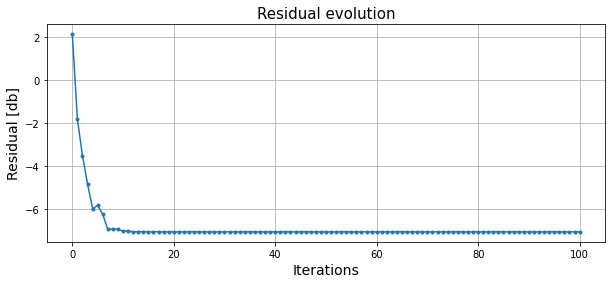

In [5]:
# check the algorithm for given matrix
import matplotlib.pyplot as plt

eig_vec = np.random.random(P.shape[0])
eig_vec, eig_val, res = power_method(P, eig_vec, 100)

plt.figure(figsize=(10,4))
plt.plot((10*np.log10(res)), '.-')
plt.title('Residual evolution', fontsize = 15)
plt.ylabel('Residual [db]', fontsize = 14)
plt.xlabel('Iterations', fontsize = 14)
plt.grid()

Here we have demonstration of the case where the method converges badly. The reason of such behaviour is the fact that we have following eigenvalues: +1, +1 , -1. For simplicity, lets assume that we have only +1 and -1 as eigenvalues. Resulting sequence will be as follows: 

$$
x_k = \frac{v_1 + \frac{c2}{c1}(-1)^kv_2 }{\|v_1 + \frac{c2}{c1}(-1)^kv_2\|} \quad k \rightarrow \infty
$$

We can see that this sequence does not converge to some value, because second value change the sign due to value of $k$. That's why we have such behaviour.

---



**2.2.5 (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?**

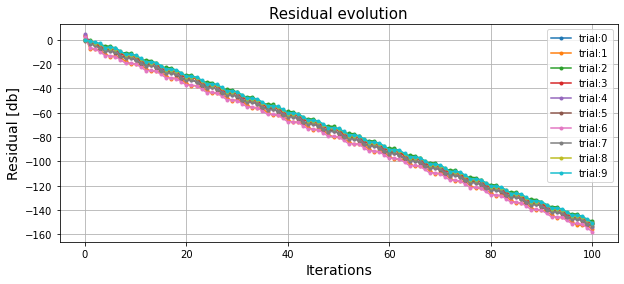

In [6]:
G = np.array([[0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [1, 1, 0, 0, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 1, 1]])
P = pagerank_matrix(G)

plt.figure(figsize=(10,4))

for i in range(10):
    eig_vec = np.random.random(P.shape[0])
    eig_vec, eig_val, res = power_method(P, eig_vec, 100)
    plt.plot((10*np.log10(res)), '.-', label = 'trial:{}'.format(i))
    #plt.plot(res, '.-', label = 'trial:{}'.format(i))

plt.title('Residual evolution', fontsize = 15)
plt.ylabel('Residual [db]', fontsize = 14)
plt.xlabel('Iterations', fontsize = 14)
plt.legend()
plt.grid()


We elimainated eigenvalue which was -1, but our graph still consist of 2 independent parts, and we have 2 eigenvalues of +1. However the sequence converges perfectly, to the combination of two eigenvectors that corresponds to 2 dominant eigenvalues:

$$
x_k = \frac{v_1 + \frac{c2}{c1}v_2 }{\|v_1 + \frac{c2}{c1}v_2\|} \quad k \rightarrow \infty
$$

But it's not the result that we expect. Resulting vector $x_k$ is not the sought eigenvector.
Moreover we can see that curve depend on the initial vector $x_0$. The reason is the fact that for different trials we have different multiplier $\frac{c2}{c1}$.

---

In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.


**2.2.6 (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.**

In [7]:
def add_weak_links(A, dampling_factor = 0.85):
    R = np.ones((A.shape)) / A.shape[0]
    A_corrected = dampling_factor*A + (1-dampling_factor)*R
    return A_corrected

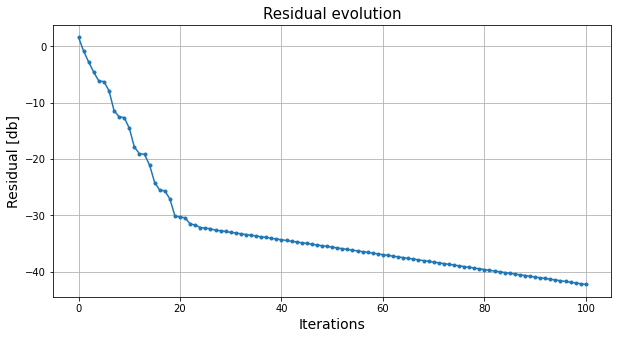

In [8]:
P_corrected = add_weak_links(P, 0.97)

plt.figure(figsize=(10,5))

eig_vec = np.random.random(P_corrected.shape[0])
eig_vec, eig_val, res = power_method(P_corrected, eig_vec,100)
plt.plot((10*np.log10(res)), '.-')

plt.title('Residual evolution', fontsize = 15)
plt.ylabel('Residual [db]', fontsize = 14)
plt.xlabel('Iterations', fontsize = 14)
plt.grid()

---


**2.2.7 (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix  Ad . How and why is it connected to the damping factor  d ? What is the convergence rate of the PageRank algorithm when using damping factor?**

In [ ]:
eig_vals, eig_vecs = np.linalg.eig(P)
eig_vals_d, eig_vecs_d = np.linalg.eig(P_corrected)

eig_vals = eig_vals[np.argsort(abs(eig_vals))][::-1]
eig_vals_d = eig_vals_d[np.argsort(abs(eig_vals_d))][::-1] 

eig_v = ['{:.2f}'.format(i) for i in eig_vals]
eig_vd = ['{:.2f}'.format(i) for i in eig_vals_d]

print('Original: ')
print(eig_v)
print('With damping:')
print(eig_vd)

Original: 
['1.00+0.00j', '1.00+0.00j', '-0.50-0.50j', '-0.50+0.50j', '-0.50+0.00j']
With damping:
['1.00+0.00j', '0.97+0.00j', '-0.49-0.49j', '-0.49+0.49j', '-0.49+0.00j']


It can be seen that one dominant eigenvalue haven't changed. But all the other eigenvalues are multiplied by damping factor $d$. Moreover it can be seen that multiplication original matrix to dampling factor leads multiplication all the eigenvalues of the original matrix, and adding term $(1-d)\cdot R$ to the result leads the recovering the dominant eigenvalue from multiplication to the initial value.

So conergence rate will be $q^k$, where $q = \left|\frac{d\lambda_{2}}{\lambda_{1}}\right| < 1$, for $\lambda_1>\lambda_2\geq\dots\geq \lambda_n$ and $k$

---

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


**2.2.8 (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output.** 

In [ ]:
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    # enter your code here
    A_shape = A.shape[0]
    x_shape = x.shape[0]

    x1 = d*A @ x 
    x2 = (1-d)* np.ones(x_shape) * np.sum(x)/A_shape
    y = x1+x2 

    return y


**2.2.9 (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.**

In [ ]:
n = 10**4                       # matrix size
density = 100/(n**2)            # n_non_zero elements / n_all_elements
A = scipy.sparse.random(n, n, density=density) 
x = np.random.random(n)

In [ ]:
t1 = %timeit -n5 -r5 -o -q pagerank_matvec(A,0.85, x)
t1

<TimeitResult : 5 loops, best of 5: 176 µs per loop>

In [ ]:
t2 = %timeit -n5 -r5 -o -q add_weak_links(A)@x
t2

<TimeitResult : 5 loops, best of 5: 370 ms per loop>

In [ ]:
print('Speedup: ', '{:.0f}'.format(t2.best/t1.best), ' times')

Speedup:  2102  times


---

#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.


**2.2.10 (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.**
 

In [ ]:
# Easy downloading directly to colab
!gdown --id 1a77VOi_XAOXQLGEsVauBHU5WpnzyS57-
!unzip dblp.zip

Downloading...
From: https://drive.google.com/uc?id=1a77VOi_XAOXQLGEsVauBHU5WpnzyS57-
To: /content/dblp.zip
100% 488M/488M [00:02<00:00, 204MB/s]
Archive:  dblp.zip
replace dblp_authors.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dblp_graph.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [ ]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [ ]:
# Your code is here
N_stored_elements = G.getnnz()
N_all_elements = np.prod(G.shape)
density = N_stored_elements/N_all_elements # number of all stored elements including explicit zeros

print("N_stored     : ", N_stored_elements)
print("All_elements : ",N_all_elements)
print("Density      :  {:.6f}".format(density))

N_stored     :  140388901
All_elements :  3120688303209
Density      :  0.000045


In [ ]:
total_cited = np.asarray(np.sum(G,axis =0)).flatten()
most_cited = total_cited.argsort()[-10:][::-1]

for index in most_cited:
  print(f'Author name: {authors[index]}. Number of citations: {int(total_cited[index])}')

Author name: Scott Shenker. Number of citations: 119853
Author name: Andrew Zisserman. Number of citations: 118558
Author name: Hari Balakrishnan. Number of citations: 117253
Author name: Jiawei Han. Number of citations: 116708
Author name: Anil K. Jain. Number of citations: 113874
Author name: Cordelia Schmid. Number of citations: 102996
Author name: Jitendra Malik. Number of citations: 101657
Author name: Ion Stoica. Number of citations: 98017
Author name: David E. Culler. Number of citations: 95762
Author name: David G. Lowe. Number of citations: 93678


In [ ]:
P = pagerank_matrix(G)

A = np.squeeze(np.asarray(P.sum(0)))
ans = (np.isclose(A,1)+np.isclose(A,0)).all() # we also have to check sum equal to 0, because of 'dangling node' problem
print('Matrix is stochastic: ', ans)

Matrix is stochastic:  True


---


2.2.11 (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<)


In [ ]:
import scipy.sparse.linalg
del G

A = P.copy()
d = 0.85

L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))

---

**2.2.12 (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.**


In [ ]:
num_iter = 100
vector_ones = np.ones(A.shape[0])

x, l, res = power_method(L, vector_ones, num_iter)

Text(0.5, 1.0, 'Residuals vs number of iterations')

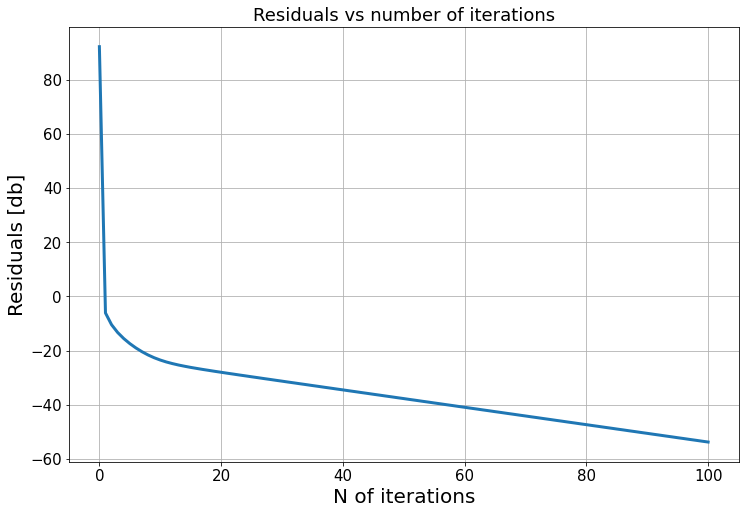

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(10*np.log10(res), linewidth = 3)
plt.xlabel('N of iterations', fontsize=20)
plt.ylabel('Residuals [db]', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.title(r'Residuals vs number of iterations', fontsize=18)

---
 
**2.2.13 (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.**

In [ ]:
most_cited_dblp = x.argsort()[-10:][::-1]

for index in most_cited_dblp:
  print(f'Author name: {authors[index]}')

Author name: Wei Wang
Author name: Yang Liu
Author name: Wei Zhang
Author name: Lajos Hanzo
Author name: Leonard Barolli
Author name: Lei Zhang
Author name: Jun Zhang
Author name: Wei Li
Author name: Jun Wang
Author name: Lei Wang


I also checked https://dblp.org/statistics/prolific1.html and it turned out, that most names coincides with list from the link. Therefore I can conclude that it works good.

---

## Problem 3. QR algorithm (33 pts)

* Implement QR-algorithm without shifts. Prototype of the function is given below

In [ ]:
import numpy as np 
import scipy 
from scipy import linalg
import matplotlib.pyplot as plt

In [ ]:
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration
def qr_algorithm(A_init, num_iter): # 3 pts
    # enter your code here
    Ak = A_init                     # put inital matrix
    convergence = []                # list for convergence

    for iter in range(num_iter):
        Q,R = scipy.linalg.qr(Ak)                               # do QR decomposition 
        convergence.append(np.amax(np.abs(np.tril(Ak, k=-1))))  # Calculate Chebyshev norm from lower subdiagonal matrix
        #convergence.append(np.linalg.norm(np.tril(Ak, k=-1), np.inf)) # Option for inf norm
        Ak = R @ Q      # multiply Q R  in inverse order
    
    return Ak, convergence

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

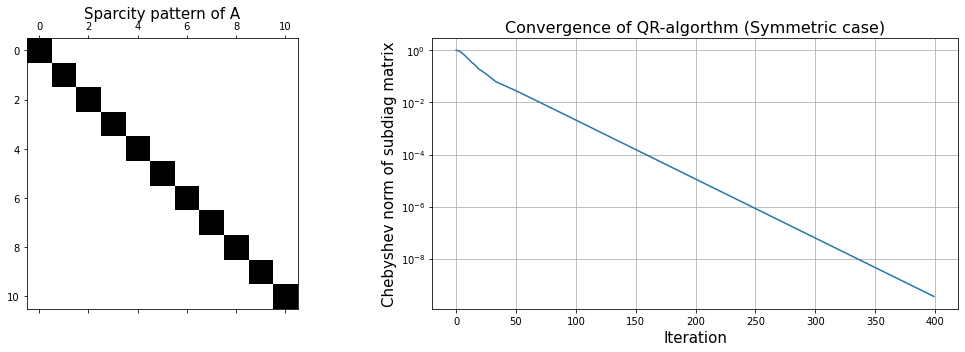

In [ ]:
# Your solution is here
from scipy.sparse import diags 
n = 11         # matrix size
n_iter = 400   # Number of iterations
A = diags([-1, 2, -1], [-1, 0, 1], shape=(n, n)).toarray() # create required symmetric matrix 

Ak, conv = qr_algorithm(A,n_iter)   # do QR algorithm

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.spy(Ak, precision=1e-7)        
plt.title('Sparcity pattern of A', fontsize = 15)

plt.subplot(1,2,2)
plt.plot(conv)
plt.yscale('log')
plt.grid()
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Chebyshev norm of subdiag matrix', fontsize = 15)
plt.title('Convergence of QR-algorthm (Symmetric case)', fontsize = 16)
plt.tight_layout()

#### Nonsymmetric case (5 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

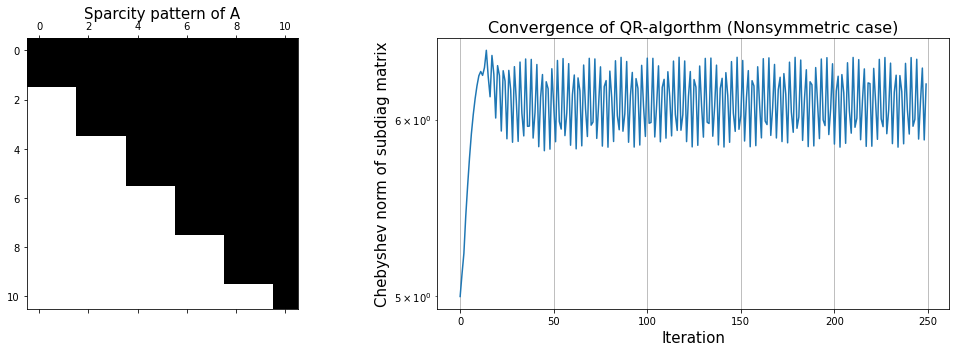

In [ ]:
# Your solution is here
from scipy.sparse import diags 
n = 11          # matrix size
n_iter = 250    # number of iterations
A = diags([5, 3, -2], [-1, 0, 1], shape=(n, n)).toarray() #Create required nonsymmetric matrix 

Ak, conv = qr_algorithm(A,n_iter)   # do QR algorithm

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.spy(Ak, precision=1e-7)
plt.title('Sparcity pattern of A', fontsize = 15)

plt.subplot(1,2,2)
plt.plot(conv)
plt.yscale('log')
plt.grid()
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Chebyshev norm of subdiag matrix', fontsize = 15)
plt.title('Convergence of QR-algorthm (Nonsymmetric case)', fontsize = 16)
plt.tight_layout()

In nonsymmetric case we don't have a triangular matrix, because nonsymmetric matrix has complex eigenvalues

### QR algorithms with Rayleigh Quotient shift (10 pts)

In the lectures the Rayleigh Quotient shift was introduced to speed up convergence of power method. Here we ask you to generalize this approach to construct the shifts in QR algorithm.

- How to compute the Rayleigh Quotient shift in QR algorithm fast? Provide formulas and explanations how they can be simplified.
- Implement explicit QR algorithm with Rayleigh Quotient shift. Please do not worry about implicit orthogonalization, we want to compare convergence only in terms of iterations.
- Test your implementation in the symmetric case. Plot the convergence of QR algorithm with and without shift. Choose the dimension $n \sim 100 $ for more representative results. 
- How the convergence of the shifted algorithm compares to the simple QR? Why? 

---

Rayleigh shift for QR-algorithm can be calculated as follows:
$$
\mu^{(k)} = \frac{(q_m^{(k)})^TAq_m^{(k)}}{(q_m^{(k)})^Tq_m^{(k)}}
$$
Where $q_m^{(k)}$ is the last column of $Q^{(k)} $ matrix. Since $Q^{(k)}$ is orthogonal, then the denominator will be equal to 1. Therefore:
$$
\frac{(q_m^{(k)})^TAq_m^{(k)}}{(q_m^{(k)})^Tq_m^{(k)}} = (q_m^{(k)})^TAq_m^{(k)} 
$$
This can be rewritten as follows:
$$
(q_m^{(k)})^TAq_m^{(k)} = e^T_m[Q^{k}]^TAQ^{(k)}e_m = e^T_mA^{(k)}e_m=A_{mm}^{(k)}
$$
So, we can see that for Rayleigh shift in QR-algorithm we can choose last right bottom element of the matrix $A$

In [ ]:
def qr_algorithm_reileigh(A_init, num_iter):
    # enter your code here
    Ak = A_init             # put initial value
    convergence = []        # list of convergence
    mu = 0                  # initialize shift 
    I = np.eye(Ak.shape[0]) # Identity matrix
    
    for iter in range(num_iter):
        
        Q,R = scipy.linalg.qr(Ak - mu*I)    # Before QR decomposition we substract shift multiplied with identity 
        convergence.append(np.amax(np.abs(np.tril(Ak, k=-1)))) # Calculate Chebyshev norm
        
        Ak = R @ Q + mu*I   # Multiply Q R in inverse order and add shift to the result
        mu = Ak[-1,-1]  # For next iteration choose shift as last bottom element of the matrix 

    return Ak, convergence

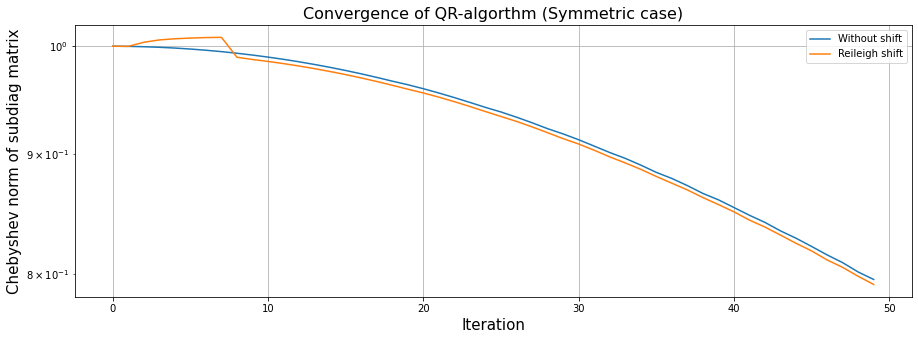

In [ ]:
n = 100         # matrix size  
n_iter = 50     # number of iterations
A = diags([-1, 2, -1], [-1, 0, 1], shape=(n, n)).toarray() # Create symmetric matrix

Ak, conv = qr_algorithm(A,n_iter)                           # apply simple qr algorithm
Ak_shifted, conv_shifted = qr_algorithm_reileigh(A,n_iter)  # apply qr algorithm with Reileigh shift 

plt.figure(figsize = (15,5))
plt.plot(conv, label = 'Without shift')
plt.plot(conv_shifted, label = 'Reileigh shift')
plt.yscale('log')
plt.grid()
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Chebyshev norm of subdiag matrix', fontsize = 15)
plt.title('Convergence of QR-algorthm (Symmetric case)', fontsize = 16)
plt.legend();

Since shift increases the gap between eigenvalues, then convergence is better, than without shift. 

- Try QR with Rayleigh Quotient shift for a simple matrix $A = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}$. Does anything change from iteration to iteration? Does shift affect convergence here? Why?

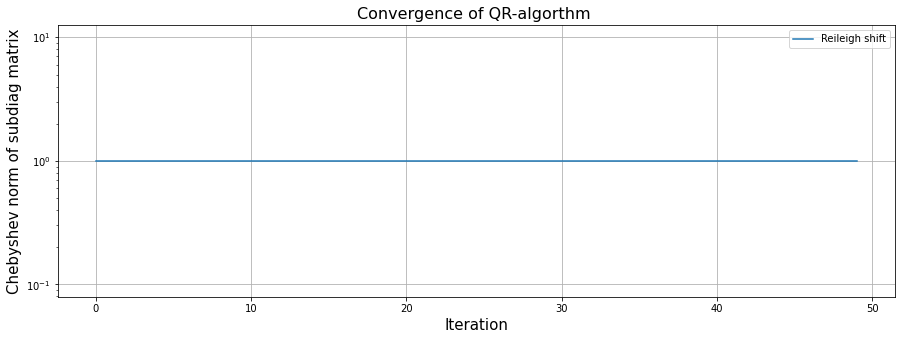

In [ ]:
# Your solution is here
A = np.array([[0,1],[1,0]])     # creat proposed matrix 
n_iter = 50                     # number of iterations for QR

Ak_shifted, conv_shifted = qr_algorithm_reileigh(A,n_iter)  # Apply QR with Reileigh shift
plt.figure(figsize = (15,5))
plt.plot(conv_shifted, label = 'Reileigh shift')
plt.yscale('log')
plt.grid()
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Chebyshev norm of subdiag matrix', fontsize = 15)
plt.title('Convergence of QR-algorthm ', fontsize = 16)
plt.legend();

For this matrix we have the following situation $A = QR = RQ$. Then it doesn't change after iterations of QR algorithm. However the Rayleigh shift doesn't help us because $A_{mm} = 0$. And the same value keeps on all iterations, that's why it doesn't work.  

### QR with Wilkinson shift  (15 pts)

To solve the problem that appears in the last example, we can use the Wilkinson shift:

$$\mu = a_m - \frac {sign(\delta) b^2_{m-1}} {(|\delta| + \sqrt{\delta^2 + b^2_{m-1}} )},$$

where $\delta = \frac{(a_{m-1} - a_m)}{2}$. If $\delta = 0$, then instead of $sign(\delta)$ you have to choose $1$ or $-1$ arbitrary.
The numbers $a_m, b_{m-1}, a_{m-1}$ are taken from matrix $B$:

$$
    B = 
    \begin{bmatrix} 
     a_{m-1} & b_{m-1} \\ 
     b_{m-1} & a_m \\ 
    \end{bmatrix},
$$  
which is a lower right bottom submatrix of $A^{(k)}$. Here $k$ is an iteration counter in QR algorithm.

- Compare convergence in the symmetric cases: 
    - distinctive eigenvalues
    - two coincident eigenvalues
    - maximum and minimum eigenvalues with the same absolute value
Choose the dimension $n \sim 100 $ for more representative results.
What do you observe? 

In [ ]:
def qr_algorithm_wilkinson(A_init, num_iter):
    # enter your code here
    def wilkinson(B):
        delta = (B[0,0] - B[1,1])/2   

        if np.isclose(delta, 0, atol=1e-12):  # if delta is close to zero, then choose the sign randomly
            delta = np.random.choice([-1,1])

        return B[1,1] - (np.sign(delta)*B[0,1]**2)/(abs(delta) + np.sqrt(delta**2+B[0,1]**2))
     
    Ak = A_init
    convergence = []
    n = Ak.shape[1]     # shape of matrix
    I = np.eye(n)       # Identity

    for iter in range(num_iter):
        mu = wilkinson(Ak[-2:, -2:])    # calculate Wilkinson shift 
        Q,R = scipy.linalg.qr(Ak - mu*I)    # subtract shift and do QR decomposition
        convergence.append(np.amax(np.abs(np.tril(Ak, k=-1))))  # calc Chebyshev norm
        #convergence.append(np.linalg.norm(np.tril(Ak, k=-1), np.inf))
        Ak = R @ Q + mu*I       # multiply Q R in inverse order and add shift 
    
    return Ak, convergence

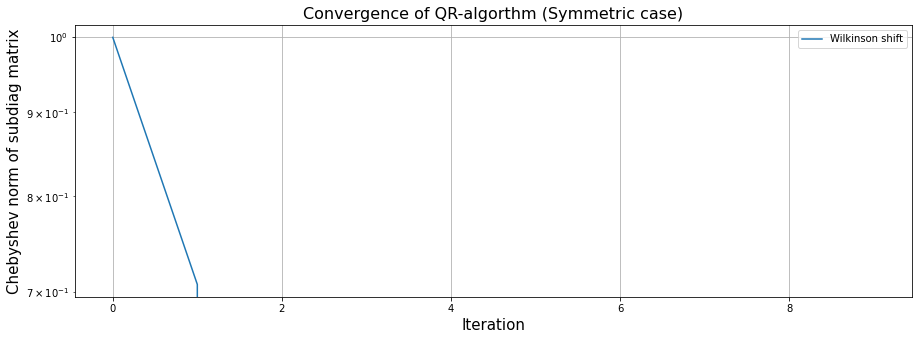

In [ ]:
# Your solution is here
A = np.array([[0,1],[1,0]])
n_iter = 10

Ak_shifted, conv_shifted = qr_algorithm_wilkinson(A,n_iter)
plt.figure(figsize = (15,5))
plt.plot(conv_shifted, label = 'Wilkinson shift')
plt.yscale('log')
plt.grid()
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Chebyshev norm of subdiag matrix', fontsize = 15)
plt.title('Convergence of QR-algorthm (Symmetric case)', fontsize = 16)
plt.legend();

Here we can see that Wilkinson shift helps us to deal with symmetry and algorithm converges.

In [ ]:
from tqdm.notebook import tqdm

def gen_with_distinctive(size):
    '''
    Generates random symmetric matrix with qudratic exponential decay of eigenvalues by
    generating elements of eigendecomposition and multiplies it 
    '''
    H = np.random.rand(size,size) # Create random matrix 
    Q,_ = np.linalg.qr(H)         # find ortogonal matrix of eigenvectors (to have symetric matrix)
    A = np.diag(np.exp((1/np.arange(1,size+1))**2)) # Create diagonal matrix with eigenvalues
    return Q@A@Q.T #calculate sought matrix

def gen_with_coincides(size):
    '''
    Generates random symmetric matrix with exponential decay of eigenvalues 
    and 2 equal maximal eigenvalues 
    by generating elements of eigendecomposition and multiplies it 
    '''
    H = np.random.rand(size,size)   # random matrix
    Q,_ = np.linalg.qr(H)           # find orthogonal
    eigvals = np.concatenate((np.array([1]), np.arange(1, size))) # prepare values for eigenvalues
    A = np.diag(np.exp(1/eigvals)) # create diag matrix with eigenvalues
    return Q@A@Q.T

def gen_with_dif_abs(size):
    '''
    Generates random symmetric matrix with exponential decay of eigenvalues 
    and 2 opposite by sign, equal by abs dominant eigenvalues
    '''
    H = np.random.rand(size,size) # random matrix 
    Q,_ = np.linalg.qr(H)         # orthogonal matrix 
    eigvals = np.concatenate((np.array([1]), np.arange(1, size))) # prepare eignvalues
    eigvals = np.exp(1/eigvals)
    eigvals[0] *= -1  
    A = np.diag(eigvals) # cheate diag matrix with eigenvalues 
    return Q@A@Q.T


  0%|          | 0/200 [00:00<?, ?it/s]

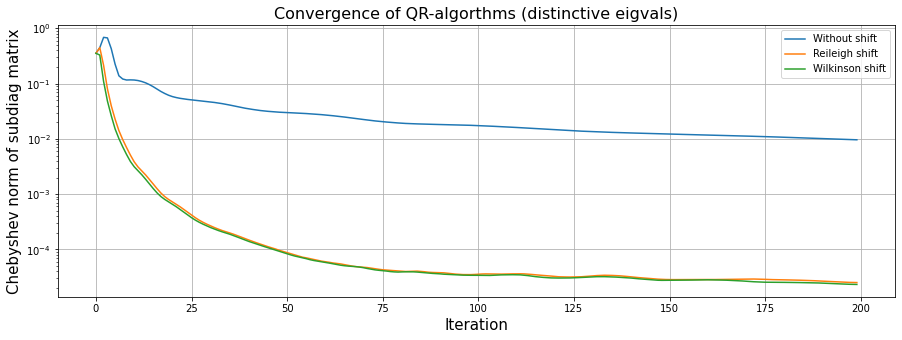

In [ ]:
# CASE WITH DISTINCTIVE EIGENVALUES 
n = 100         #matrix size
n_iter = 200    
REPEATS = 200   # number of experiments 

Conv_simple = np.zeros((REPEATS, n_iter))   # storage for convergenca data for simple QR
Conv_reileigh = np.zeros((REPEATS, n_iter)) # storage for convergenca data for QR with Reileigh shift
Conv_wilkinson = np.zeros((REPEATS, n_iter))# storage for convergenca data for QR with WIlkinson shift

for repeat in tqdm(range(REPEATS)):     # repeat experiment 200 times 
    A = gen_with_distinctive(n)         # create matrix with distinctive eigenvalues
    A = scipy.linalg.hessenberg(A)      # transform it to Hessinberg form. (For better convergence and fast calculation)
    Ak, conv = qr_algorithm(A,n_iter)   # apply simple qr algorithm
    Ak_shifted, conv_shifted = qr_algorithm_reileigh(A,n_iter)      #apply qr with Reileigh shift 
    Ak_shifted2, conv_shifted2 = qr_algorithm_wilkinson(A,n_iter)   # apply qr with Wilkinson shift

    Conv_simple[repeat,:] = conv                # add current values to storage 
    Conv_reileigh[repeat,:] = conv_shifted
    Conv_wilkinson[repeat,:] = conv_shifted2


# Plot meaned over all experiments graphs
plt.figure(figsize = (15,5))
plt.plot(np.mean(Conv_simple,axis = 0), label = 'Without shift')
plt.plot(np.mean(Conv_reileigh,axis = 0), label = 'Reileigh shift')
plt.plot(np.mean(Conv_wilkinson,axis = 0), label = 'Wilkinson shift')

plt.yscale('log')
plt.grid()
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Chebyshev norm of subdiag matrix', fontsize = 15)
plt.title('Convergence of QR-algorthms (distinctive eigvals)', fontsize = 16)
plt.legend();

So we can see that with large gap between eigenvalues all algorithms converges, but shifted versions do it much faster

  0%|          | 0/200 [00:00<?, ?it/s]

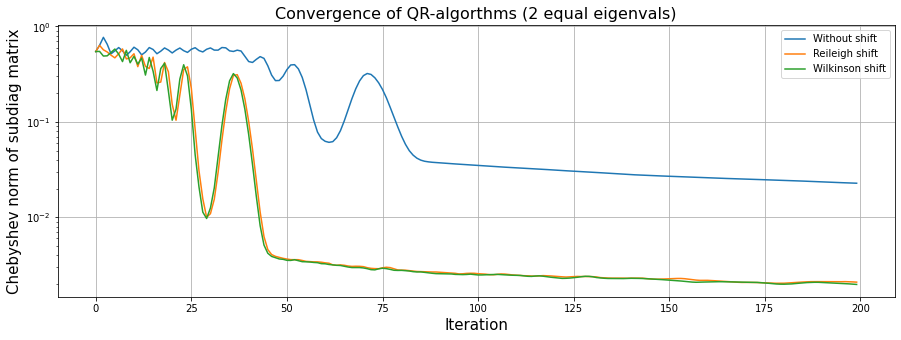

In [ ]:
# CASE WITH 2 EQUAL DOMINANT EIGENVALUES
n = 100         # matrix size
n_iter = 200    

REPEATS = 200
Conv_simple = np.zeros((REPEATS, n_iter))
Conv_reileigh = np.zeros((REPEATS, n_iter))
Conv_wilkinson = np.zeros((REPEATS, n_iter))

for repeat in tqdm(range(REPEATS)):

    A = gen_with_coincides(n)           # create matrix with 2 equal eigenvalues 
    A = scipy.linalg.hessenberg(A)      # transform it to Hessinberg form. (For better convergence and reducing complexity) 
    Ak, conv = qr_algorithm(A,n_iter)   # apply simple QR algorithm
    Ak_shifted, conv_shifted = qr_algorithm_reileigh(A,n_iter)    #apply QR algorithm with Reileigh shift 
    Ak_shifted2, conv_shifted2 = qr_algorithm_wilkinson(A,n_iter) # apply Qr algorithm with Wilkinson shift 

    Conv_simple[repeat,:] = conv
    Conv_reileigh[repeat,:] = conv_shifted
    Conv_wilkinson[repeat,:] = conv_shifted2

# Plot meaned over all experiments graphs
plt.figure(figsize = (15,5))
plt.plot(np.mean(Conv_simple,axis = 0), label = 'Without shift')
plt.plot(np.mean(Conv_reileigh,axis = 0), label = 'Reileigh shift')
plt.plot(np.mean(Conv_wilkinson,axis = 0), label = 'Wilkinson shift')

plt.yscale('log')
plt.grid()
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Chebyshev norm of subdiag matrix', fontsize = 15)
plt.title('Convergence of QR-algorthms (2 equal eigenvals)', fontsize = 16)
plt.legend();

If 2 eigenvalues coincides then algorithms converges with oscilations, but finally they decays. Moreover the asymptote of convergence is higher than in previous case, so in such situation, algorithms converges worse than in case where we have distinctive eigenvalues.

  0%|          | 0/200 [00:00<?, ?it/s]

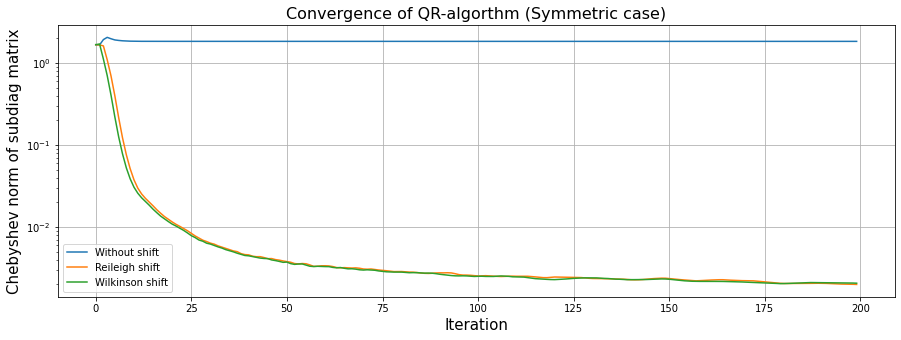

In [ ]:
# CASE WITH OPPOSITE DOMINANT EIGENVALUES    
n = 100 
n_iter = 200
REPEATS = 200
Conv_simple = np.zeros((REPEATS, n_iter))
Conv_reileigh = np.zeros((REPEATS, n_iter))
Conv_wilkinson = np.zeros((REPEATS, n_iter))

for repeat in tqdm(range(REPEATS)):

    A = gen_with_dif_abs(n)
    A = scipy.linalg.hessenberg(A)
    Ak, conv = qr_algorithm(A,n_iter)
    Ak_shifted, conv_shifted = qr_algorithm_reileigh(A,n_iter)
    Ak_shifted2, conv_shifted2 = qr_algorithm_wilkinson(A,n_iter)
    
    Conv_simple[repeat,:] = conv
    Conv_reileigh[repeat,:] = conv_shifted
    Conv_wilkinson[repeat,:] = conv_shifted2


plt.figure(figsize = (15,5))
plt.plot(np.mean(Conv_simple,axis = 0), label = 'Without shift')
plt.plot(np.mean(Conv_reileigh,axis = 0), label = 'Reileigh shift')
plt.plot(np.mean(Conv_wilkinson,axis = 0), label = 'Wilkinson shift')

plt.yscale('log')
plt.grid()
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Chebyshev norm of subdiag matrix', fontsize = 15)
plt.title('Convergence of QR-algorthm (Symmetric case)', fontsize = 16)
plt.legend();

Here we can see that simple qr algorithm doesn't converge at all. While algorithms with shifts performs with the same way when we have the same eigenvalues and smoothly converges.

## Problem 4. (Movie Recommender system) 15 pts

Imagine the world without NLA where you have free evenings and you can watch movies!  
But it is always hard to choose a movie to watch. 
In this problem we suggest you to build your own movie recommender system based on SVD decomposition, so you can combine two perfect things: Numerical Linear Algebra and cinematography!

In order to build recommender system you need data. 
Here you are https://grouplens.org/datasets/movielens/1m/

Usually all recommender systems may be devided into two groups

#### Collaborative filtering. 

This approach is based on user-item interaction.
It has one important assumption: user who has liked an item in the past will also likes the same in the future. Suppose the user A likes the films about vampires. 
He is Twilight saga fan and he has watched the film "What we do in the shadows" and liked it or unliked it, in other words he evaluated it somehow. And suppose another user B, who has the similair behavior to the first user (he is also Twilight saga fan). And the chance, that he will estimate "What we do in the shadows" in the same way that user A did, is huge. So, the purpose of the collaborative filtering is to predict a user's behavior based on behavior of the simular users.

#### Content based filtering.

Collaborative filtering has some essential flaws. The main one is called "cold start". "Cold start" happens when the new user comes and he has not react anyhow to the items. So we do not know his past behavior and we do not know what to advise. Here content based filtering helps. Often resources gather some extra info about users and items before a user comes down to utilising the resource. So, for example we would know that user likes horror movies before he watched anything on the resource.


- In this task you will implement Collaborative filtering based on SVD (we will use the function from the proper package and check if the result recommender system advices the similar movies)

1) (1 pts)  Explore the data. Construct the interaction matrix $M$ of size $m \times n$ which contains the information of how a certain user rated a certain film. 

2) (5 pts)  Compute SVD of this matrix. Remeber that matrix $M$ is sparse (one user can hardly watch all the movies) so the good choice would be to use method from ```scipy.sparse.linalg``` package

$$ M = USV^{\top}, $$

where $U$ is a $m \times r $ orthogonal matrix with left singular vectors, which represents the relationship between users and latent factors, $S$ is a $r \times r $ diagonal matrix, which describes the strength of each latent factor and $V^\top$ is a $r \times n$ matrix with right singular vectors, which represent the embeddings of  items (movies in our case) in latent space.
Describe any simple heuristic to choose appropriate value for $r$ and explain why do you expect that it will work.


In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
PATH = 'ml-1m/'

--2021-11-30 21:13:53--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  6.16MB/s    in 0.9s    

2021-11-30 21:13:55 (6.16 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd

# Read the dataset
movies = pd.read_table(PATH + 'movies.dat',
                       names=['MovieID','Title','Genres'],
                       encoding='latin-1',
                       engine = 'python',
                       delimiter='::')

ratings = pd.read_table(PATH + 'ratings.dat',
                        names=['UserID','MovieID','Rating','Timestamp'],
                        encoding='latin-1',
                        engine = 'python',
                        delimiter='::')

users = pd.read_table(PATH + 'users.dat',
                      names=['UserID','Gender','Age','Occupation','Zip-code'],
                      encoding='latin-1',
                      engine = 'python',
                      delimiter='::')

# Create the interaction matrix
M = np.zeros((len(users), len(movies)))
movie_ids = np.array(movies.MovieID)
user_ids = np.array(users.UserID)


for i in range(len(ratings)):
    user_id = ratings.UserID[i]
    movie_id = ratings.MovieID[i]

    user_idx = np.argmax(user_ids == user_id)
    movie_idx = np.argmax(movie_ids == movie_id)
    M[user_idx, movie_idx] = ratings.Rating[i]


def get_mov_by_id(mov_id, mov_ids):
    idx = np.argmax(movie_ids == mov_id)
    title = movies.Title[idx]
    genre = movies.Genres[idx]
    return title, genre

def get_mov_by_idx(idx):
    title = movies.Title[idx]
    genre = movies.Genres[idx]
    return title, genre

# Normalize the matrix


In [ ]:
M.shape

(6040, 3883)

In [ ]:
# Method for calculating approximation rank

U,S,V = np.linalg.svd(M.T @ M)  # make svd of matrix multiplication 
# And sum singular values while we get 50% of accuracy 
singular_sum = np.sum(S)
r = 0
sum_current = 0
# until 50% accuracy
while np.abs(sum_current - singular_sum)/singular_sum > 0.5:
    sum_current = np.sum(S[0:r])
    r += 1
print(r)

54


In [ ]:
# Compute Singular Value Decomposition of interaction matrix. You can use built-in functions
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

M_s = csc_matrix(M,dtype = float)

U,S,V = svds(M_s, k = r) # Update this line, it is just example

3) (2 pts) In order to get weighted item-latent factors, we can multiply $S$ and $V^{T}$. Please, remember that $S$ is diagonal and multiply them efficiently.

In [ ]:
# Your solutuion is here
S = S[::-1]
V = V[::-1,:]

SV_T = S.reshape(-1,1)[0:r,:] * V[0:r,:]

Now we have vectors that represent our item space. In other words we have $N$ movies and $N$ vectors which describe each movie, a.k.a. embeddings. 
In order to know if two movies are similar or not we need just to check if the corresponding vectors are similair or not. How we can do this?

4) (2 pts)  Implement the cosine metric. If the cosine metric between two vectors equals to $1$ both vectors are collinear, if $0$ vectors are orthogonal, as a result corresponding movies are completely different.

$$
cosine(u,v) = \frac{u^{\top}v}{\|u\|_2\|v\|_2}
$$

In [ ]:
# Your solutuion is here
def cosine(u,v):
    return (u.T @ v)/np.linalg.norm(u,2)/np.linalg.norm(v,2)

5) (5 pts) Check your result. Implement the fuction, which finds and prints $k$ similar movies to the one you have chosen

In [ ]:
# Your solutuion is here
def recommend(film_idx, SV_T, k):
    recommendations  = {}
    selected = {}

    scores = []
    for idx in range(SV_T.shape[1]):
        similarity = cosine(SV_T[:,film_idx], SV_T[:,idx])
        scores.append(similarity)

    sorted_scores = sorted(scores)[-k-1:-1][::-1]

    for score in sorted_scores:
        idx = np.argmax(scores == score)
        selected[idx] = score
    
    film,genre = get_mov_by_idx(film_idx)
    print('You have chosen: ', film, '. Genre is ', genre)
    print('lets find something interesting...')
    table = {'Film name': [],'Film index': [], 'Genre': [], 'Similarity': []}

    for idx, similarity in zip(selected.keys(), selected.values()):
        film_name,genre = get_mov_by_idx(idx)
        
        table['Film name'].append(film_name)
        table['Film index'].append(idx)
        table['Genre'].append(genre)
        table['Similarity'].append(np.round(similarity,3))
    df = pd.DataFrame(table)
    #df = df.style.set_properties(**{'text-align': 'left'})
    return df


In [ ]:
k = 10
selected_film_idx = 0
recommend(selected_film_idx,SV_T,k)

You have chosen:  Toy Story (1995) . Genre is  Animation|Children's|Comedy
lets find something interesting...


,Film name,Film index,Genre,Similarity
0,Toy Story 2 (1999),3045,Animation|Children's|Comedy,0.909
1,"Bug's Life, A (1998)",2286,Animation|Children's|Comedy,0.857
2,Babe (1995),33,Children's|Comedy|Drama,0.854
3,Aladdin (1992),584,Animation|Children's|Comedy|Musical,0.849
4,Groundhog Day (1993),1245,Comedy|Romance,0.832
5,Pleasantville (1998),2252,Comedy,0.819
6,"Lion King, The (1994)",360,Animation|Children's|Musical,0.792
7,There's Something About Mary (1998),1854,Comedy,0.780
8,Babe: Pig in the City (1998),2315,Children's|Comedy,0.777
9,Wayne's World (1992),3184,Comedy,0.772


In [ ]:
selected_film_idx = 1943
recommend(selected_film_idx,SV_T,k)

You have chosen:  Back to the Future Part III (1990) . Genre is  Comedy|Sci-Fi|Western
lets find something interesting...


,Film name,Film index,Genre,Similarity
0,Back to the Future Part II (1989),1942,Comedy|Sci-Fi,0.898
1,"Rocketeer, The (1991)",2025,Action|Adventure|Sci-Fi,0.878
2,Coneheads (1993),431,Comedy|Sci-Fi,0.876
3,"Nutty Professor, The (1996)",778,Comedy|Fantasy|Romance|Sci-Fi,0.873
4,Flight of the Navigator (1986),1977,Adventure|Children's|Sci-Fi,0.869
5,Mars Attacks! (1996),1370,Action|Comedy|Sci-Fi|War,0.861
6,"Honey, I Shrunk the Kids (1989)",1985,Adventure|Children's|Comedy|Fantasy|Sci-Fi,0.847
7,Stargate (1994),313,Action|Adventure|Sci-Fi,0.845
8,Sneakers (1992),1375,Crime|Drama|Sci-Fi,0.837
9,Independence Day (ID4) (1996),770,Action|Sci-Fi|War,0.836


In [ ]:
selected_film_idx = 1000
recommend(selected_film_idx,SV_T,k)

You have chosen:  Parent Trap, The (1961) . Genre is  Children's|Drama
lets find something interesting...


,Film name,Film index,Genre,Similarity
0,Old Yeller (1957),999,Children's|Drama,0.891
1,"Journey of Natty Gann, The (1985)",2008,Adventure|Children's,0.878
2,Pollyanna (1960),1001,Children's|Comedy|Drama,0.874
3,"Little Princess, The (1939)",905,Children's|Drama,0.864
4,"Parent Trap, The (1998)",1990,Children's|Drama,0.860
5,Freaky Friday (1977),1945,Children's|Comedy,0.858
6,Swiss Family Robinson (1960),1004,Adventure|Children's,0.851
7,Bedknobs and Broomsticks (1971),1018,Adventure|Children's|Musical,0.851
8,Pete's Dragon (1977),1017,Adventure|Animation|Children's|Musical,0.836
9,"Incredible Journey, The (1963)",1988,Adventure|Children's,0.835


So, I can see that it works well, because genres are usually match each other and if film has several parts, then we usuallu have all of them in similar

Enjoy watching the recommended movies!
